coverage plot

In [113]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [114]:
num_dim = 1
prior_uniform = utils.BoxUniform(low = 0 * torch.ones(num_dim), high = 10 * torch.ones(num_dim))

In [115]:
def simple_relation(phi1s, M_sat, scatter=0.1):

    phi2s = phi1s/M_sat

    phi1s = np.array(phi1s)
    phi2s = np.array(phi2s)
    
    positions = np.concatenate([phi1s,phi2s])
    positions = torch.from_numpy(positions)
    
    return positions + torch.randn_like(positions) * scatter

# print(simple_relation(np.arange(10), 0.1, 0.1))

In [116]:
def simulator(params, n_obs=100, scatter=0.1):
    params = torch.as_tensor(params)
    M_sat = params[0]

    # phi1 values evenly spaced
    phi1s = np.arange(n_obs)
    phi1s = torch.tensor(phi1s)

    return simple_relation(phi1s, M_sat, scatter)

In [162]:
posterior = infer(simulator, prior_uniform, "SNPE", num_simulations=1000)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:00<00:00, 13438.37it/s]
/Users/rutongpei/opt/anaconda3/envs/sbi_env/lib/python3.7/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 31 epochs.

In [130]:
def hpd(trace, mass_frac):
    ''' 
    Returns highest probability density region given by a set of samples.

    Parameters
    ----------
    trace: array
        1D array of MCMC samples for a single variable
    mass_frac: float with 0 < mass_frac <= 1
        The fraction of the probability to be included in the HPD. For example, 'massfrac'=0.95 gives a 95% HPD.

    Returns
    -------
    output: array, shape(2,)
        The bounds of the HPD
    '''

    # Get sorted list
    d = np.sort(np.copy(trace))

    # Number of total samples taken
    n = len(trace)

    # Get number of samples that should be included in HPD
    n_samples = np.floor(mass_frac * n).astype(int)

    # Get width (in units of data) of all intervals with n_samples samples
    int_width = d[n_samples:] - d[:n-n_samples]

    # Pick out minimal interval
    min_int = np.argmin(int_width)

    # Return interval
    return np.array([d[min_int], d[min_int+n_samples]])

In [160]:
# simple version

def draw_coverage_plot_1d(simulator, posterior, true_values):
    fractions = np.array([])
    x = np.arange(0, 1, 0.1)

    samples = [[0] for _ in range(len(true_values))]
    for i in range(len(true_values)):
        simulated_samples = posterior.sample((1000,), x = simulator(torch.as_tensor([true_values[i]])))[:,0]
        samples[i] = np.array(simulated_samples)
    
    for confidence in x:
        contain_true = 0
        for i in range(len(true_values)):
            lower, upper = hpd(samples[i],confidence)
            if lower <= true_values[i] <= upper:
                contain_true += 1
        fractions = np.append(fractions, [contain_true/len(true_values)])

    plt.plot(x, fractions, label = 'model coverage')
    plt.plot([0,1],[0,1],color='r', label = 'perfect coverage')
    plt.ylim(0,1)
    plt.title("coverage for M_sat")
    plt.xlabel("confidence interval")
    plt.ylabel("covereage percentage")
    plt.show()

Drawing 1000 posterior samples: 1074it [00:00, 38663.48it/s]            
Drawing 1000 posterior samples: 1059it [00:00, 57203.89it/s]            
Drawing 1000 posterior samples: 1086it [00:00, 63822.53it/s]            
Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 78426.06it/s]
Drawing 1000 posterior samples: 1099it [00:00, 67219.94it/s]            
Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 73971.01it/s]
Drawing 1000 posterior samples: 1099it [00:00, 65931.57it/s]            
Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 74878.23it/s]
Drawing 1000 posterior samples: 1098it [00:00, 65427.07it/s]            
Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 72606.01it/s]
Drawing 1000 posterior samples: 1096it [00:00, 66440.58it/s]            
Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 74499.18it/s]
Drawing 1000 posterior samples: 1096it [00:00, 32808.6

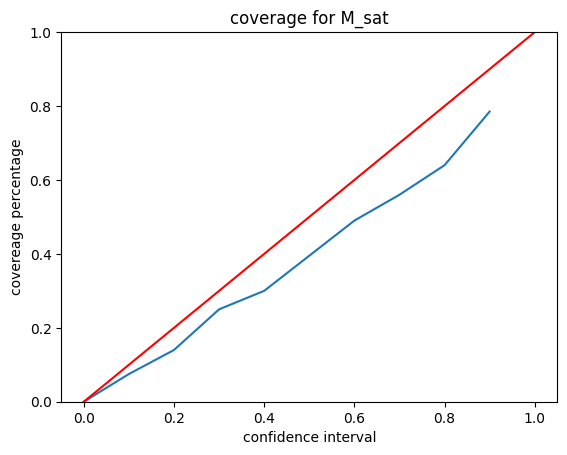

In [163]:
true_values = np.arange(0.05,10.05,0.05)
draw_coverage_plot_1d(simulator, posterior, true_values)


In [146]:
# to be updated
# input simulator (to calculate observation), trained posterior model, true_values to be tested

def draw_coverage_plot(simulator, posterior, true_values):
    fractions = np.array([])
    x = np.arange(0, 1, 0.1)
    num_variables = len(true_values[0])


    for i in range(num_variables):
        for j in x:
            contain_true = 0
            for k in true_values:
                samples = posterior.sample((1000,), x = simulator(torch.as_tensor(k)))
                lower_bound, upper_bound = hpd(np.array(samples[:,i]), j)
                if lower_bound <= k[i] <= upper_bound:
                    contain_true += 1
        
        fractions = np.append(fractions, [contain_true/len(true_values[0])])
    
    plt.plot(x, fractions)
    plt.title("f'coverage for {i}'")
    plt.show()

TypeError: object of type 'numpy.float64' has no len()